# Power Energy Transfer System: 4 vs 1

Sistema de doble aporendizaje por refuerzo, donde una matriz de antenas emite energía a una antena receptora. La posición de la antena receptora en principio es desconocida para la antena emisora. En el downlink la matriz de antenas emisoras transmitirá una cantidad determinada y siempre igual de potencia en una dirección (a decidir) y la antena receptora recibirá una cantidad de energía X según el canal (H) y la dirección del emisor. En el uplink, la antena receptora tiene que decidir si envía datos o no en base a la batería que tenga y la energía que ha captado. La antena emisora recibirá esos datos, si la receptora ha decidido enviarlos, y en base a eso recalculará la dirección. En los datos está la energía que le ha llegado al receptor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Models import modelos_indoor
from antenna_distributions import antenna_distributions as antd
from itertools import product

np.set_printoptions(legacy='1.25')
np.random.seed(2026)

1. Parámetros físicos

In [2]:
c = 3e8
freq = 5.8e9    
lam = c / freq
k = 2 * np.pi / lam

2. Parámetros de la habitación

In [3]:
room = [10.0,10.0,3.0]

3. Parámetros antena emisora:

In [4]:
num_ant = 2*2
Ptt = 100.0
Pt_i = Ptt/num_ant 
# La antena transmisora es isotrópica.
# Ganancia
G_t = 1.0

# Dos posiciones de antenas emisoras (Lambda/2 y distribuidas): 
d1 = lam / 2 
d2 = room[0] / np.sqrt(num_ant)

p_lamda2 = antd.grid_antenna_positions(num_ant,d1,room[2])
print(p_lamda2)
p_dist = antd.grid_antenna_positions(num_ant,d2,room[2])

# Ángulos a los que puede variar la fase cada una de las antenas emisoras.
# Puede sumar 0.1, restar 0.1 o quedarse donde está.
# cada uno de las antenas emisoras. 3 estados por antena.
angle_resolution = 0.1
emisor_possible_actions = 3**num_ant

print(emisor_possible_actions)

# ESTADO INICIAL:
initial_angles_emisor = []
np.random.seed(2026)
for i in range(num_ant): initial_angles_emisor.append(np.random.uniform(0, 2*np.pi))
print(initial_angles_emisor)

def permutaciones_estados(N, estados=(-0.1, 0, 0.1)):
    return list(product(estados, repeat=N))

actions_transmitter = permutaciones_estados(num_ant,(-0.1, 0, 0.1))
print(len(actions_transmitter))

# El estado depende del ángulo, y la información recibida. 
# STATE = [RESPONSE]
# REWARD = RESPONSE

[(-0.01293103448275862, -0.01293103448275862, 3.0), (-0.01293103448275862, 0.01293103448275862, 3.0), (0.01293103448275862, -0.01293103448275862, 3.0), (0.01293103448275862, 0.01293103448275862, 3.0)]
81
[1.3781892705668197, 2.5950292768487633, 6.136381686847114, 0.5585690266421656]
81


4. Parámetros de la antena receptora

In [5]:
# Dipolo vertical:
def theta_r(_tx,_rx):
    R_path = np.linalg.norm(_rx - _tx)
    cos_theta = abs((_rx - _tx))[2] / (R_path + 1e-15)
    sin_theta = np.sqrt(max(0.0, 1.0 - cos_theta**2))
    return sin_theta**2

# Posición de la antena receptora: 
r_position = np.array([3, 0, 1]) 
# Ganancia: 
G_r = 1.0

params = {'n':num_ant, 'P_total': Ptt, 'f': freq, 'G_t': G_t, 'G_r': G_r,}
print(params)

# Unidades en J/s de cada nivel de la batería (1W=1J/s). 
Eh = 0.005
B_max = 5
B_levels = np.arange(0,B_max,Eh)
print(len(B_levels))
actions = B_levels

Eh_max = 0.5
Eh_levels = np.arange(0,Eh_max,Eh)
print(len(Eh_levels))

H_levels = np.arange(0,1.1,0.1)
print(len(H_levels))

# Acciones posibles son tres: 0. No enviar nada. 1. Enviar 'baliza de estado'. 2. Captar información. 3. Enviar información.
action_0 = 0
action_1 = 0.000001
action_2 = 0.00001
action_3 = 0.0005
actions_receiver = [action_0,action_1,action_2, action_3]

# El estado depende de H, el nivel de batería y la energía captada.
# STATE = [H,B,EH]

# ESTADO INICIAL
np.random.seed(2026)
B_init = (np.random.choice(B_levels))
print(initial_angles_emisor)
power_received, probability = modelos_indoor.total_power_shadowing(p_lamda2,initial_angles_emisor,r_position,params)
print(power_received, probability)

# To quantize the values. 
def get_index(value,from_array):
    from_list = list(from_array)
    #print(from_list)
    the_index = len(from_list)-1
    for i in from_list: 
        if i > value:
            the_index = from_list.index(i)-1
            break
    return the_index

receiver_init_state = (get_index(probability,H_levels), list(B_levels).index(B_init), get_index(power_received,Eh_levels))
initial_emisor_state = (get_index(power_received,Eh_levels))
print(receiver_init_state)

{'n': 4, 'P_total': 100.0, 'f': 5800000000.0, 'G_t': 1.0, 'G_r': 1.0}
1000
100
11
[1.3781892705668197, 2.5950292768487633, 6.136381686847114, 0.5585690266421656]
0.0006077702243128578 0.6818259436700033
(6, 257, 0)


5. Parámetros Q-learning:

In [6]:
# num_episodes: Number of times the agent will attempt to navigate the maze.
num_episodes = 1000

# Tiempo por episodio
total_time=2000

# alpha: Learning rate that controls how much new information overrides old information.
alpha = 0.1
# gamma: Discount factor giving more weight to immediate rewards.
gamma = 0.9

# Q is the Q-Table initialized to zero; it stores expected rewards for each state-action pair.
# Hay 2 matrices de Q, para el emisor y el receptor.

Q_emisor = np.zeros((len(Eh_levels),)+(len(actions_transmitter),))
print(Q_emisor.shape)

Q_receiver = np.zeros((len(H_levels),)+(len(B_levels),)+(len(Eh_levels),)+(len(actions_receiver),))
print(Q_receiver.shape)


(100, 81)
(11, 1000, 100, 4)


6. Acciones válidas para ambos emisores y receptor

In [7]:
# Como mínimo, se envía la energía en overflow, si se da la situación.

def valid_energy_transfer(state): # No se da ni de locura
    E_overflow = max(state[2]+min(state[1],B_max)-B_max,0)
    available_actions = state[0]
    valid_actions = [
        a for a in actions
        if E_overflow <= a <= available_actions
    ]
    return valid_actions

In [8]:
# Devuelve el valor de valid_actions (índices) que es máximo en Q[state].
def get_Q_max_action(valid_actions,state,Q):
    return int(max(valid_actions, key=lambda a: Q[state][a]))

def explotation_vs_exploration(valid_actions,state, epsilon,Q): #receptor
    if np.random.random() < epsilon:
        #Exploration (Probability e)
        return int(np.random.choice(valid_actions))
    else: 
        #Explotation (Probability 1-e)
        return int(get_Q_max_action(valid_actions, state,Q))

In [9]:
def Reward_emisor(power_received):
    return power_received*100

def Reward_receiver(action_used, informacion_captada,H_prob): #?
    if(action_used == 0):
        return 0*H_prob
    elif(action_used == 1):
        return 1*H_prob
    elif(action_used == 2):
        return 1*H_prob
    elif(action_used == 3):
        return min(informacion_captada, 10)*H_prob
    else: 
        return print("Error. Acción fuera de rango.")


In [10]:
reward_transmitter_all_episodes = []
reward_receiver_all_episodes = []

valid_actions_idx_receiver = list(range(len(actions_receiver)))
valid_actions_idx_transmitter = list(range(len(actions_transmitter)))

epsilon = 0.2

for episode in range(num_episodes):
    total_rewards_transmitter = 0
    total_rewards_receiver = 0
    state_transmitter = int(initial_emisor_state)
    state_receiver = tuple(int(x) for x in receiver_init_state)
    informacion_captada = 0
    baliza_enviada = 0
    angles_transmitter = initial_angles_emisor
    for time in range(total_time):
        if time % 2 == 0:
            #receiver
            # STATE = [H,B,EH]
            H_idx, B_idx,  EH_idx = state_receiver
            """ H_idx = list(H_levels).index(H_prob)
            B_idx = list(B_levels).index(B_state)
            EH_idx = list(Eh_levels).index(EH_state) """
            
            action_receiver_index = explotation_vs_exploration(valid_actions_idx_receiver,state_receiver,epsilon, Q_receiver)
            if action_receiver_index == 2:
                informacion_captada += 1
                baliza_enviada = 0
            elif action_receiver_index == 1:
                baliza_enviada = Eh_levels[EH_idx]
            else: 
                baliza_enviada = 0
            
            reward_receiver = Reward_receiver(action_receiver_index,informacion_captada, H_levels[H_idx])
            next_B = min(B_levels[B_idx] + Eh_levels[EH_idx] - actions_receiver[action_receiver_index], B_max)
            next_B_idx = get_index(next_B,B_levels)

            old_value_receiver = Q_receiver[H_idx,B_idx, EH_idx][action_receiver_index]
            total_rewards_receiver += reward_receiver
            

        else:
            # transmitter
            reward_transmitter = Reward_emisor(baliza_enviada)

            action_transmitter_index = explotation_vs_exploration(valid_actions_idx_transmitter,state_transmitter,epsilon, Q_emisor)
            angles_transmitter += actions_transmitter[action_transmitter_index]
            power_received, probability = modelos_indoor.total_power_shadowing(p_lamda2,angles_transmitter,r_position,params)
            
            # el receiver se actualiza aquí, según el nuevo ángulo del transmitter. 
            next_H_idx = get_index(probability,H_levels)
            next_EH_idx = get_index(power_received,Eh_levels)
            next_receiver_state = (next_H_idx,next_B_idx, next_EH_idx)
            next_receiver_max = max(Q_receiver[next_receiver_state])
            Q_receiver[state_receiver][action_receiver_index] += alpha*(reward_receiver + gamma*next_receiver_max - old_value_receiver)
            state_receiver = next_receiver_state
            
            # teniendo nuevo ángulo en el transmisor:
            old_value_transmitter = Q_emisor[state_transmitter][action_transmitter_index]
            next_state_transmitter = next_EH_idx
            next_max_transmitter = max(Q_emisor[next_state_transmitter])
            Q_emisor[state_transmitter][action_transmitter_index] += alpha*(reward_transmitter + gamma*next_max_transmitter - old_value_transmitter)
            state_transmitter = next_state_transmitter
            total_rewards_transmitter += reward_transmitter


    reward_transmitter_all_episodes.append(total_rewards_transmitter)
    reward_receiver_all_episodes.append(total_rewards_receiver)
            


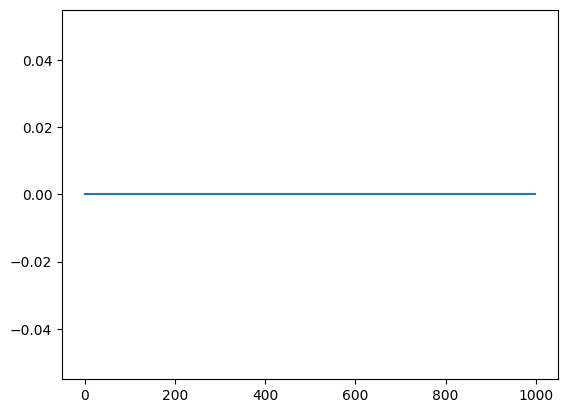

In [11]:
plt.plot(range(len(reward_transmitter_all_episodes)), reward_transmitter_all_episodes)

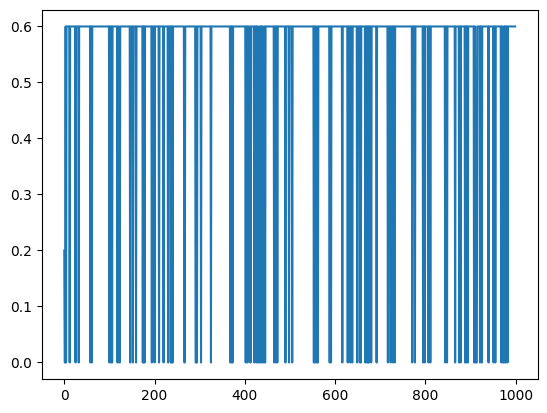

In [12]:
plt.plot(range(num_episodes), reward_receiver_all_episodes)